# Spam Classification using LLM


In [42]:
import pandas as pd
from tqdm import tqdm

## Data Preparation


In [43]:
train_df = pd.read_csv("./input/deceptive-opinion-spam-corpus/deceptive-opinion.csv")

In [44]:
# Testing on a smaller portion of the dataset
test_df = train_df.groupby("deceptive").sample(200)

In [45]:
test_df.value_counts("deceptive")

deceptive
deceptive    200
truthful     200
Name: count, dtype: int64

In [46]:
test_df.to_csv("./results/llm/llm_test_dataset.csv", index=False)

## OpenAI API


In [47]:
from openai import OpenAI

client = OpenAI()

In [48]:
def get_few_shot_prompt(n_shots=3):
    """
    Generate a few-shot prompt by randomly selecting n examples from the training data.
    Ensure that the number of truthful and deceptive examples are equal, and handle odd n_shots.
    Formats the prompt in a user/assistant conversation format.

    Args:
        n_shots (int): Number of examples to include in the prompt

    Returns:
        str: Formatted prompt with few-shot examples in ChatGPT conversation format
    """
    # Randomly sample n examples from training data
    # Sample equal numbers of truthful and deceptive reviews, handling odd n_shots
    n_per_class = n_shots // 2
    remaining = n_shots % 2

    # Get base samples for each class
    deceptive = train_df[train_df["deceptive"] == "deceptive"].sample(n=n_per_class)
    truthful = train_df[train_df["deceptive"] == "truthful"].sample(n=n_per_class)

    # If n_shots is odd, randomly add one more example from either class
    if remaining:
        extra_sample = train_df.sample(n=1)
        few_shot_examples = pd.concat([deceptive, truthful, extra_sample]).sample(
            frac=1
        )
    else:
        few_shot_examples = pd.concat([deceptive, truthful]).sample(frac=1)

    few_shot_prompts = []
    # Add the few-shot examples in conversation format
    for _, example in few_shot_examples.iterrows():
        few_shot_prompts.append({"role": "user", "content": f"{example['text']}"})
        few_shot_prompts.append(
            {"role": "assistant", "content": f"{example['deceptive']}"}
        )

    return few_shot_prompts

In [49]:
def get_response(prompt, model="gpt-4o-mini", n_shots=0):
    """
    Get a response from the OpenAI API for a given prompt.

    Args:
        prompt (str): The text message to be classified
        model (str, optional): The OpenAI model to use. Defaults to "gpt-4o-mini"
        n_shots (int, optional): Number of examples to include. Defaults to 0.

    Returns:
        str: The model's classification response (ideally 'truthful' or 'deceptive')
    """

    system_role = f"""You are a classification model trained to identify whether incoming messages are spam. 
    Given a message, analyze its content, structure, and intent to determine if it is 'truthful' (not spam) or 'deceptive' (spam). 
    Return 'truthful' if the message does not contain signs of spam and is a genuine communication. 
    Return 'deceptive' if the message displays characteristics commonly associated with spam, such as misleading claims, requests for sensitive information, or excessive promotions."""

    # Build messages list starting with system role
    messages = [{"role": "system", "content": system_role}]

    # Add example messages based on n_shots
    if n_shots > 0:
        # Get few-shot examples - In-Context Learning
        context = get_few_shot_prompt(n_shots)
        # Add pairs of examples up to n_shots
        messages.extend(context)

    # Add the actual prompt
    messages.append({"role": "user", "content": prompt})

    completion = client.chat.completions.create(model=model, messages=messages)

    return completion.choices[0].message.content

## Helper Functions


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

In [51]:
def count_predictions(result):
    """
    Count occurrences of each class and check for invalid predictions.
    """
    # Count occurrences of each class
    deceptive_count = result.count("deceptive")
    truthful_count = result.count("truthful")

    # Print the counts
    print(f"Total predictions: {len(result)}")
    print(f"Number of deceptive predictions: {deceptive_count}")
    print(f"Number of truthful predictions: {truthful_count}")
    print(
        f"Number of invalid predictions: {len(result) - deceptive_count - truthful_count}"
    )
    print()

    # Check for any invalid predictions
    for i in result:
        if i != "deceptive" and i != "truthful":
            print(f"Invalid prediction found: \n{i}")

In [52]:
def get_classification_report(y_true, y_pred, result):
    """
    Get classification report.
    """
    # Filter out invalid predictions
    for pred in result:
        if pred in ["deceptive", "truthful"]:
            y_pred.append(pred)
        else:
            # For invalid predictions, we'll count them as incorrect by using the opposite of true label
            true_idx = len(y_pred)  # Get index to find corresponding true label
            y_pred.append(
                "truthful" if y_true[true_idx] == "deceptive" else "deceptive"
            )

    # Print classification report with all metrics
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

In [53]:
def get_confusion_matrix(y_true, y_pred):
    """
    Get confusion matrix and visualize it.
    """
    # Calculate confusion matrix using sklearn
    conf_matrix = confusion_matrix(y_true, y_pred, labels=["deceptive", "truthful"])

    # Create heatmap visualization of confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        xticklabels=["deceptive", "truthful"],
        yticklabels=["deceptive", "truthful"],
    )
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [54]:
def save_results(result, n_shots):
    """
    Save results to a CSV file.
    """
    # Create a DataFrame with test data and predictions
    results_df = test_df.copy()
    results_df["predicted"] = result

    # Save to CSV file
    results_df.to_csv(f"./results/llm/prediction_results_{n_shots}.csv", index=False)
    print(f"Results saved to prediction_results_{n_shots}.csv")

## Zero-shot


In [55]:
# Get response from LLM and store in result
result = []

for text in tqdm(test_df.text):
    response = get_response(text)
    result.append(response)

100%|██████████| 400/400 [02:58<00:00,  2.24it/s]


### Save result to csv file


In [56]:
save_results(result, 0)

Results saved to prediction_results_0.csv


### Validation


In [57]:
count_predictions(result)

Total predictions: 400
Number of deceptive predictions: 2
Number of truthful predictions: 398
Number of invalid predictions: 0



_Note_: LLM response containing "truthful" or "deceptive" may be considered as respective valid predictions, but for the purpose of evaluation, we will count them as invalid here.


In [58]:
# Convert predictions and actual values to lists
y_true = list(test_df.deceptive)
y_pred = []

Classification Report:
              precision    recall  f1-score   support

   deceptive       1.00      0.01      0.02       200
    truthful       0.50      1.00      0.67       200

    accuracy                           0.51       400
   macro avg       0.75      0.51      0.34       400
weighted avg       0.75      0.51      0.34       400



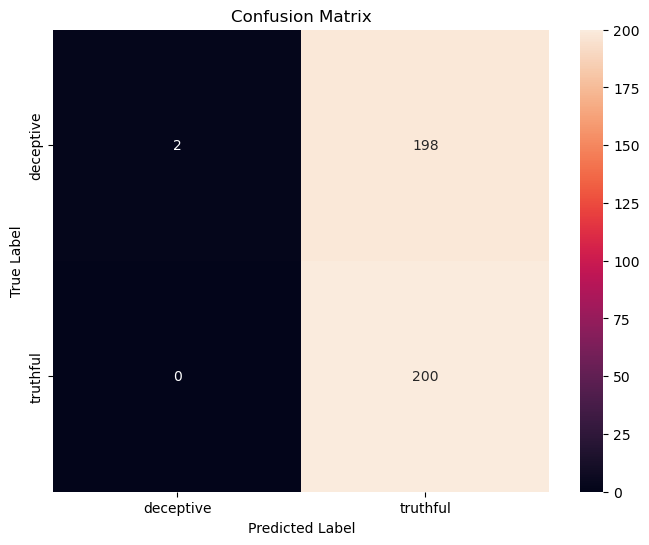

In [60]:
get_classification_report(y_true, y_pred, result)
get_confusion_matrix(y_true, y_pred)

### Analysis


For "deceptive" class, 71% of the times the model predicted "deceptive", it was correct; 29% of the times it was incorrect. For "truthful" class, 50% of the times the model predicted "truthful", it was correct; 50% of the times it was incorrect.

For "deceptive" class, only 1% of actual deceptive cases were correctly identified, and 99% of deceptive cases were misclassified as truthful. For "truthful" class, 100% of actual truthful cases were correctly identified, but it was not meaningful since the model predicted "truthful" for most cases (99.56%).

The f1-score for "deceptive" class is 0.01, which is very low, although the f1-score for "truthful" class is 0.67, again it is not meaningful for the reason mentioned above.

In conclusion, the statistics above show that the LLM model is not able to distinguish between deceptive and truthful messages.


## Few-shot


In [61]:
def get_few_shot_results(n_shots):
    """
    Helper function to pipeline the process of getting few-shot results.
    """
    result = []

    # Iterate through each text in the test dataset
    for text in tqdm(test_df.text):
        response = get_response(text, n_shots=n_shots)
        result.append(response)

    # Save results to csv file
    save_results(result, n_shots)

    # Count and print predictions
    count_predictions(result)

    # Convert predictions and actual values to lists
    y_true = list(test_df.deceptive)
    y_pred = []

    # Get classification report
    get_classification_report(y_true, y_pred, result)

    # Get confusion matrix
    get_confusion_matrix(y_true, y_pred)

### 1-shot


In [62]:
result = []

for text in tqdm(test_df.text):
    response = get_response(text, n_shots=1)
    result.append(response)

100%|██████████| 400/400 [03:06<00:00,  2.14it/s]


In [63]:
save_results(result, 1)

Results saved to prediction_results_1.csv


In [64]:
count_predictions(result)

Total predictions: 400
Number of deceptive predictions: 35
Number of truthful predictions: 365
Number of invalid predictions: 0



In [65]:
# Convert predictions and actual values to lists
y_true = list(test_df.deceptive)
y_pred = []

Classification Report:
              precision    recall  f1-score   support

   deceptive       0.63      0.11      0.19       200
    truthful       0.51      0.94      0.66       200

    accuracy                           0.52       400
   macro avg       0.57      0.52      0.42       400
weighted avg       0.57      0.52      0.42       400



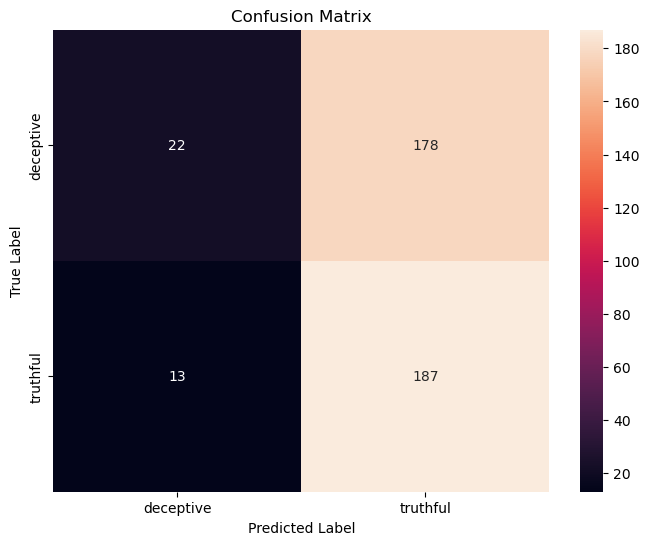

In [66]:
get_classification_report(y_true, y_pred, result)
get_confusion_matrix(y_true, y_pred)

### 2-shot


100%|██████████| 400/400 [03:09<00:00,  2.12it/s]

Results saved to prediction_results_2.csv
Total predictions: 400
Number of deceptive predictions: 82
Number of truthful predictions: 318
Number of invalid predictions: 0

Classification Report:
              precision    recall  f1-score   support

   deceptive       0.67      0.28      0.39       200
    truthful       0.54      0.86      0.67       200

    accuracy                           0.57       400
   macro avg       0.61      0.57      0.53       400
weighted avg       0.61      0.57      0.53       400



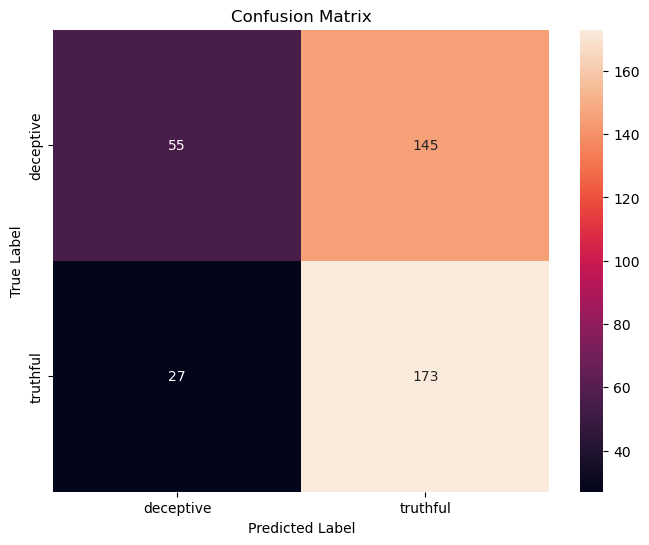

In [67]:
get_few_shot_results(2)

### 3-shot


100%|██████████| 400/400 [03:18<00:00,  2.02it/s]

Results saved to prediction_results_3.csv
Total predictions: 400
Number of deceptive predictions: 89
Number of truthful predictions: 311
Number of invalid predictions: 0

Classification Report:
              precision    recall  f1-score   support

   deceptive       0.62      0.28      0.38       200
    truthful       0.53      0.83      0.65       200

    accuracy                           0.55       400
   macro avg       0.58      0.55      0.52       400
weighted avg       0.58      0.55      0.52       400



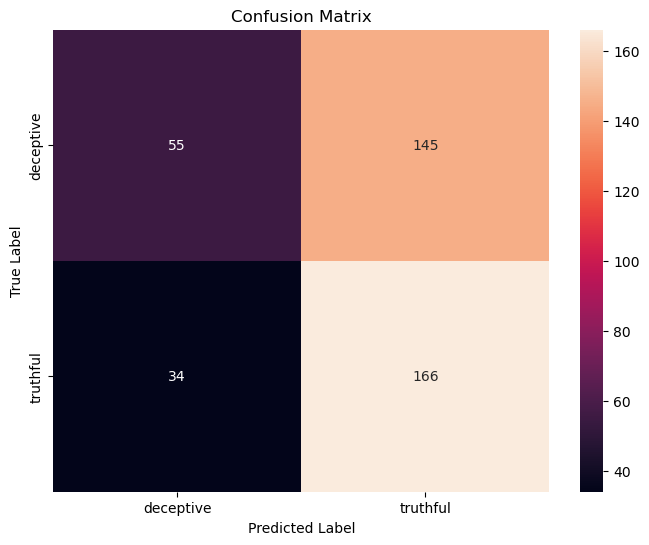

In [71]:
get_few_shot_results(3)

### 4-shot


100%|██████████| 400/400 [03:13<00:00,  2.07it/s]

Results saved to prediction_results_4.csv
Total predictions: 400
Number of deceptive predictions: 118
Number of truthful predictions: 282
Number of invalid predictions: 0

Classification Report:
              precision    recall  f1-score   support

   deceptive       0.66      0.39      0.49       200
    truthful       0.57      0.80      0.66       200

    accuracy                           0.59       400
   macro avg       0.61      0.59      0.58       400
weighted avg       0.61      0.59      0.58       400



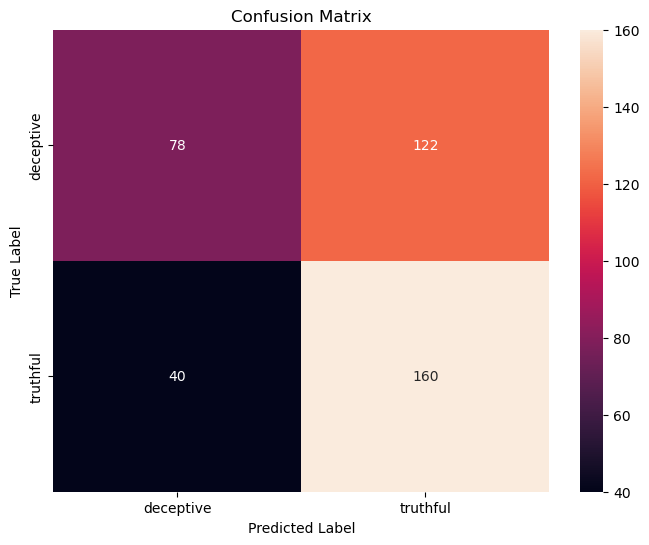

In [72]:
get_few_shot_results(4)

# Calculate Accuracy



Results for 0-shot:
Accuracy: 0.5050
Correct predictions: 202
Total predictions: 400

Results for 1-shot:
Accuracy: 0.5225
Correct predictions: 209
Total predictions: 400

Results for 2-shot:
Accuracy: 0.5700
Correct predictions: 228
Total predictions: 400

Results for 3-shot:
Accuracy: 0.5525
Correct predictions: 221
Total predictions: 400

Results for 4-shot:
Accuracy: 0.5950
Correct predictions: 238
Total predictions: 400


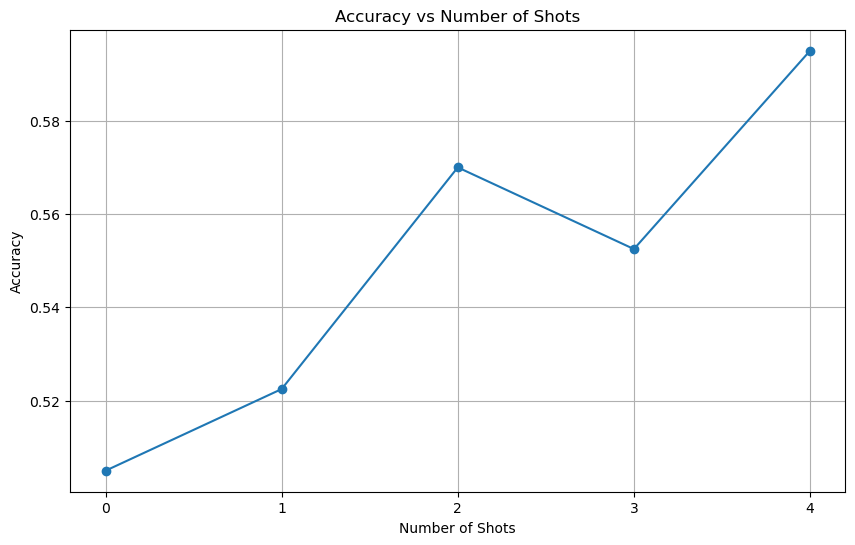

In [73]:
def calculate_accuracy_from_files(n_shots_list):
    """
    Calculate accuracy metrics for different n-shot results.

    Args:
        n_shots_list (list): List of n_shot values to analyze

    Returns:
        dict: Dictionary containing accuracy scores for each n_shot value
    """
    accuracy_results = {}

    for n_shots in n_shots_list:
        # Read the results file
        results_df = pd.read_csv(f"./results/llm/prediction_results_{n_shots}.csv")

        # Calculate accuracy
        correct_predictions = (results_df["deceptive"] == results_df["predicted"]).sum()
        total_predictions = len(results_df)
        accuracy = correct_predictions / total_predictions

        # Store results
        accuracy_results[n_shots] = accuracy

        print(f"\nResults for {n_shots}-shot:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Correct predictions: {correct_predictions}")
        print(f"Total predictions: {total_predictions}")

    return accuracy_results


# Calculate accuracy for 0-shot, 1-shot, and 2-shot results
n_shots_list = [0, 1, 2, 3, 4]
accuracy_results = calculate_accuracy_from_files(n_shots_list)

# Visualize results
plt.figure(figsize=(10, 6))
plt.plot(list(accuracy_results.keys()), list(accuracy_results.values()), marker='o')
plt.title('Accuracy vs Number of Shots')
plt.xlabel('Number of Shots')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(range(5))  # Set x-axis ticks to show integers 0-4
plt.show()